# Курсовой проект для курса "Python для Data Science"

## Задание:

Используя данные из обучающего датасета (train.csv), построить модель для предсказания цен на недвижимость (квартиры). С помощью полученной модели, предсказать цены для квартир из тестового датасета (test.csv).

Целевая переменная: Price

Метрика качества: R2 - коэффициент детерминации (sklearn.metrics.r2_score)

## Описание датасета: 

- Id - идентификационный номер квартиры
- DistrictId - идентификационный номер района
- Rooms - количество комнат
- Square - площадь
- LifeSquare - жилая площадь
- KitchenSquare - площадь кухни
- Floor - этаж
- HouseFloor - количество этажей в доме
- HouseYear - год постройки дома
- Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
- Social_1, Social_2, Social_3 - социальные показатели местности
- Healthcare_1, Helthcare_2 - показатели местности по охране здоровья
- Shops_1, Shops_2 - показатели местности по наличию магазинов
- Price - цена квартиры

## Подключаем библиотеки и их модули

In [292]:
import numpy as np
import pandas as pd
import random
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score as r2
%matplotlib inline

In [348]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [349]:
import warnings
warnings.filterwarnings('ignore')

In [350]:
matplotlib.rcParams.update({'font.size': 14})

In [351]:
def evaluate_preds(true_values, pred_values):
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)))
        
    plt.figure(figsize=(10,10))
    
    sns.scatterplot(x=pred_values, y=true_values)
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    plt.show()

## Загружаем данные

In [500]:
TRAIN_DATASET_PATH = './train.csv'
TEST_DATASET_PATH = './test.csv'
PREDICTIONS_PATH = './Voroberv_predictions.csv'

In [501]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

In [502]:
train_df.head(5)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [503]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

## Начинаем анализ и обработку данных

In [504]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


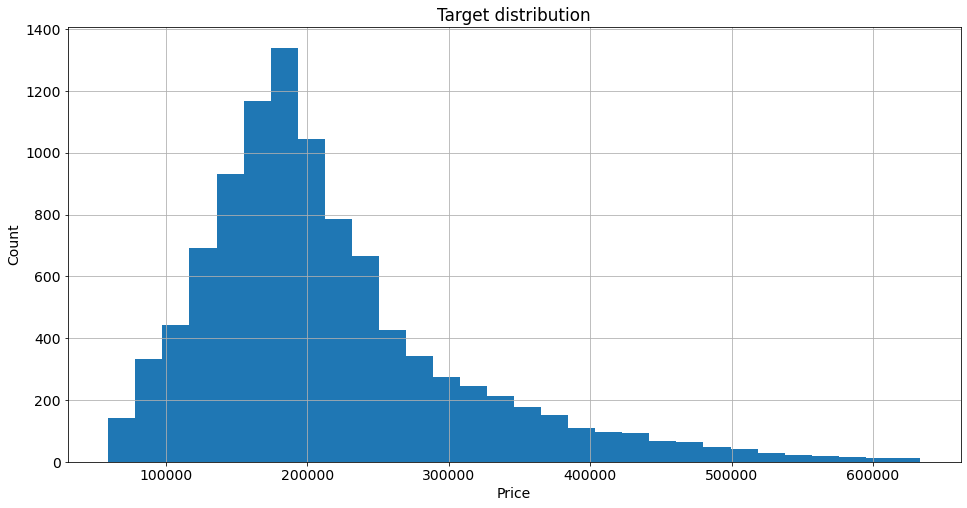

In [505]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

In [506]:
train_df['Ecology_2_bin'] = train_df['Ecology_2'].replace({'A':0, 'B':1})
train_df['Ecology_3_bin'] = train_df['Ecology_3'].replace({'A':0, 'B':1})
train_df['Shops_2_bin'] = train_df['Shops_2'].replace({'A':0, 'B':1})

In [507]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
6.0        1
19.0       1
Name: Rooms, dtype: int64

In [508]:
train_df.loc[train_df['Rooms'].isin([0, 6, 10, 19]), 'Rooms'] = train_df['Rooms'].median()

In [509]:
train_df.loc[train_df['LifeSquare'].isnull(), 'LifeSquare'] = train_df['LifeSquare'].median()
train_df.loc[train_df['LifeSquare'] < 10, 'LifeSquare'] = 10
train_df.loc[train_df['LifeSquare'] > 100, 'LifeSquare'] = 100

In [510]:
train_df.loc[train_df['KitchenSquare'] < 6, 'KitchenSquare'] = train_df['KitchenSquare'].median()
train_df.loc[train_df['KitchenSquare'] > 20, 'KitchenSquare'] = train_df['KitchenSquare'].median()

In [511]:
overrun = train_df['Square'] < train_df['LifeSquare'] + train_df['KitchenSquare']
train_df.loc[overrun].describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
count,1344.000000,1344.000000,1344.000000,1344.000000,1344.000000,1344.000000,1344.000000,1344.000000,1344.000000,1344.000000,1344.000000,1344.000000,1344.000000,474.000000,1344.000000,1344.000000,1344.000000,1344.000000,1344.000000,1344.000000
mean,8411.166667,32.389881,1.659226,54.528466,53.780075,6.979911,9.788690,13.998512,1997.745536,0.107290,14.470982,3370.406994,8.773065,844.911392,0.781250,3.336310,183444.589856,0.998512,0.991815,0.894345
std,4826.809824,27.537745,0.771768,18.840509,18.777983,1.939605,5.867359,8.608296,19.944655,0.111924,16.216032,3760.143149,29.536400,660.415569,1.293114,5.342477,90301.389056,0.038561,0.090131,0.307510
min,6.000000,0.000000,1.000000,1.136859,10.000000,6.000000,1.000000,0.000000,1918.000000,0.000000,0.000000,168.000000,0.000000,30.000000,0.000000,0.000000,59877.592523,0.000000,0.000000,0.000000
25%,4154.500000,9.000000,1.000000,40.219853,39.652347,6.000000,5.000000,9.000000,1977.000000,0.012168,2.000000,469.000000,0.000000,540.000000,0.000000,0.000000,122148.789137,1.000000,1.000000,1.000000
50%,8531.500000,27.000000,1.000000,50.643520,50.351975,6.000000,9.000000,17.000000,2014.000000,0.072158,6.000000,1564.000000,1.000000,645.000000,0.000000,1.000000,162052.527587,1.000000,1.000000,1.000000
75%,12501.750000,48.000000,2.000000,66.254452,65.862648,6.000000,14.000000,17.000000,2016.000000,0.195781,23.000000,5735.000000,3.000000,1046.000000,1.000000,5.000000,217098.785406,1.000000,1.000000,1.000000
max,16782.000000,187.000000,5.000000,109.905861,100.000000,20.000000,28.000000,117.000000,2020.000000,0.486246,74.000000,19083.000000,141.000000,4508.000000,6.000000,23.000000,573999.459148,1.000000,1.000000,1.000000


##### Так как площадь квартиры состоит не только из жилой площади и площади кухни, но и площади коридора, сан-узла, и т.д., на личном примере имеющихся данных из жизни я подсчитал что примерная относительная площадь коридора и сан-узла равна около 30%-40% от суммарной жилой площади и площади кухни. Переработаем все данные площади по этому примеру взяв средние 35%

In [512]:
train_df['Square'] = train_df['LifeSquare'] + train_df['KitchenSquare'] + 0.35 * (train_df['LifeSquare'] + train_df['KitchenSquare'])

In [513]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.888400,57.834706,35.383723,7.45680,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399,0.990300,0.972500,0.917500
std,4859.01902,43.587592,0.811056,20.607088,14.842676,2.04371,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865,0.098015,0.163543,0.275139
min,0.00000,0.000000,1.000000,21.600000,10.000000,6.00000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,0.000000,0.000000,0.000000
25%,4169.50000,20.000000,1.000000,44.529071,25.527399,6.00000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942,1.000000,1.000000,1.000000
50%,8394.50000,36.000000,2.000000,52.354701,32.781260,6.00000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879,1.000000,1.000000,1.000000
75%,12592.50000,75.000000,2.000000,65.942176,41.427234,9.00000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171,1.000000,1.000000,1.000000
max,16798.00000,209.000000,5.000000,160.650000,100.000000,20.00000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570,1.000000,1.000000,1.000000


In [514]:
train_df.loc[train_df['HouseFloor'] < train_df['Floor']].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
17,1190,8,2.0,46.304460,28.299600,6.0,6,5.0,1962,0.458174,...,4439,1,1130.0,1,5,B,186971.926566,1,0,1
19,367,45,1.0,62.116914,40.012529,6.0,16,14.0,2015,0.195781,...,5212,6,NaN,3,2,B,250466.980777,1,1,1
21,8471,20,3.0,74.917739,47.494621,8.0,11,9.0,1976,0.019509,...,7687,11,176.0,5,5,B,366916.246494,1,1,1
24,4717,27,1.0,52.354701,32.781260,6.0,2,0.0,1977,0.072158,...,629,1,NaN,0,0,A,135466.559958,1,1,0
25,4521,6,2.0,52.354701,32.781260,6.0,18,1.0,1977,0.243205,...,1564,0,540.0,0,0,B,191205.272608,1,1,1


In [515]:
train_df.loc[train_df['HouseFloor'] < train_df['Floor'], 'HouseFloor'] = train_df['Floor']

In [516]:
train_df.loc[train_df['HouseYear'] > 2021, 'HouseYear'] = 2021

## Теперь вычислим стоимость квадратного метра квартиры и на основе этих данных создадим новые признаки

In [517]:
train_df['m2_Price'] = train_df['Price'] / train_df['Square']

In [518]:
m2PriceByDistrict = train_df.groupby(['DistrictId'], as_index=False).agg({'m2_Price':'median'})\
                    .rename(columns={'m2_Price':'m2PriceByDistrict'})
m2PriceByHouseYear = train_df.groupby(['HouseYear'], as_index=False).agg({'m2_Price':'median'})\
                    .rename(columns={'m2_Price':'m2PriceByHouseYear'})

In [519]:
train_df = train_df.merge(m2PriceByDistrict, on=['DistrictId'], how='left')
train_df = train_df.merge(m2PriceByHouseYear, on=['HouseYear'], how='left')
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,m2_Price,m2PriceByDistrict,m2PriceByHouseYear
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,...,5202.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.888400,57.834706,35.383723,7.45680,8.526700,13.435700,1984.872600,0.118858,...,1142.904460,1.319500,4.231300,214138.857399,0.990300,0.972500,0.917500,3914.420126,3771.778041,3700.229323
std,4859.01902,43.587592,0.811056,20.607088,14.842676,2.04371,5.241148,6.094012,18.416734,0.119025,...,1021.517264,1.493601,4.806341,92872.293865,0.098015,0.163543,0.275139,1700.777222,933.933503,716.799707
min,0.00000,0.000000,1.000000,21.600000,10.000000,6.00000,1.000000,1.000000,1910.000000,0.000000,...,0.000000,0.000000,0.000000,59174.778028,0.000000,0.000000,0.000000,609.228490,2000.730041,2531.023724
25%,4169.50000,20.000000,1.000000,44.529071,25.527399,6.00000,4.000000,9.000000,1974.000000,0.017647,...,350.000000,0.000000,1.000000,153872.633942,1.000000,1.000000,1.000000,2886.620006,2819.976531,3055.453867
50%,8394.50000,36.000000,2.000000,52.354701,32.781260,6.00000,7.000000,14.000000,1977.000000,0.075424,...,900.000000,1.000000,3.000000,192269.644879,1.000000,1.000000,1.000000,3859.841355,3999.979356,4033.486620
75%,12592.50000,75.000000,2.000000,65.942176,41.427234,9.00000,12.000000,17.000000,2001.000000,0.195781,...,1548.000000,2.000000,6.000000,249135.462171,1.000000,1.000000,1.000000,4659.252000,4338.643068,4202.469965
max,16798.00000,209.000000,5.000000,160.650000,100.000000,20.00000,42.000000,117.000000,2021.000000,0.521867,...,4849.000000,6.000000,23.000000,633233.466570,1.000000,1.000000,1.000000,28298.653335,8775.453771,8867.324983


## Отбираем признаки для модели

In [520]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 
                 'HouseFloor', 'HouseYear', 'Ecology_1','Social_1', 'Social_3', 
                 'Helthcare_2', 'Shops_1', 'Ecology_2_bin', 'Ecology_3_bin',
                 'Shops_2_bin', 'm2PriceByDistrict', 'm2PriceByHouseYear']
target_name = 'Price'

In [521]:
df = train_df[feature_names + [target_name]]
df.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_3,Helthcare_2,Shops_1,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,m2PriceByDistrict,m2PriceByHouseYear,Price
0,3.0,57.754701,32.781260,10.0,4,10.0,2014,0.075424,11,0,0,0,1,1,1,2643.456152,2531.023724,305018.871089
1,1.0,42.078451,23.169223,8.0,7,8.0,1966,0.118537,30,1,1,0,1,1,1,3636.897601,4074.355857,177734.553407
2,3.0,77.857162,47.671972,10.0,2,17.0,1988,0.025609,33,0,3,1,1,1,1,3124.959120,4429.444399,282078.720850
3,1.0,52.354701,32.781260,6.0,10,22.0,1977,0.007122,1,0,0,1,1,1,1,3124.959120,3055.453867,168106.007630
4,2.0,64.209398,38.562517,9.0,16,16.0,1972,0.282798,33,2,0,6,1,1,1,4020.168030,4102.008032,343995.102962


In [522]:
scaler = StandardScaler()
stand_features = scaler.fit_transform(df[feature_names])
df[feature_names] = pd.DataFrame(stand_features, columns=feature_names)
df.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_3,Helthcare_2,Shops_1,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,m2PriceByDistrict,m2PriceByHouseYear,Price
0,1.370628,-0.003883,-0.175345,1.244466,-0.863728,-0.563811,1.581652,-0.364931,-0.780698,-0.337347,-0.883480,-0.880402,0.09897,0.16816,0.299864,-1.208200,-1.631228,305018.871089
1,-1.095417,-0.764642,-0.822972,0.265804,-0.291306,-0.892019,-1.024804,-0.002690,0.303050,-0.295384,-0.213923,-0.880402,0.09897,0.16816,0.299864,-0.144429,0.521966,177734.553407
2,1.370628,0.971678,0.827941,1.244466,-1.245343,0.584915,0.169821,-0.783473,0.474169,-0.337347,1.125190,-0.672333,0.09897,0.16816,0.299864,-0.692610,1.017371,282078.720850
3,-1.095417,-0.265941,-0.175345,-0.712857,0.281117,1.405433,-0.427491,-0.938799,-1.351093,-0.337347,-0.883480,-0.672333,0.09897,0.16816,0.299864,-0.692610,-0.899565,168106.007630
4,0.137605,0.309360,0.214177,0.755135,1.425961,0.420811,-0.698997,1.377425,0.474169,-0.253421,-0.883480,0.368011,0.09897,0.16816,0.299864,0.265974,0.560545,343995.102962


## Приступаем к обучению модели

In [523]:
X = df[feature_names]
y = df[target_name]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.45, shuffle=True, random_state=42)

In [524]:
gb_model = GradientBoostingRegressor(criterion='mse', max_depth=5, n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(criterion='mse', max_depth=5, random_state=42)

R2:	0.875


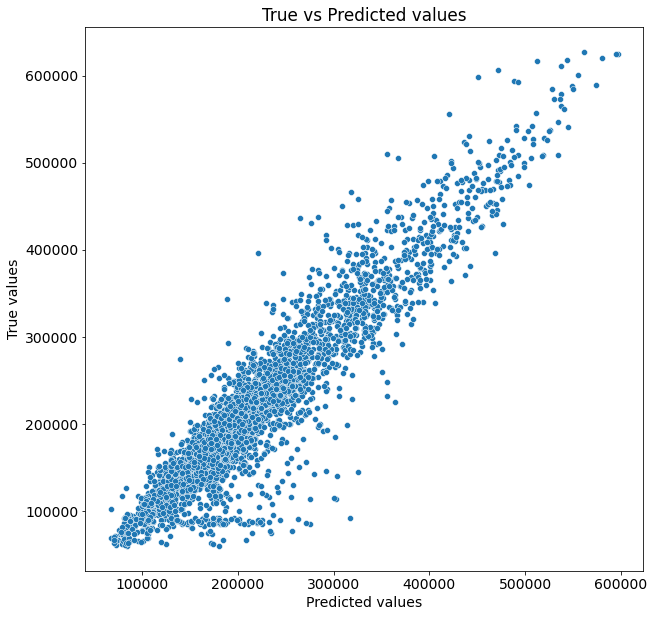

In [525]:
y_train_preds = gb_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.705


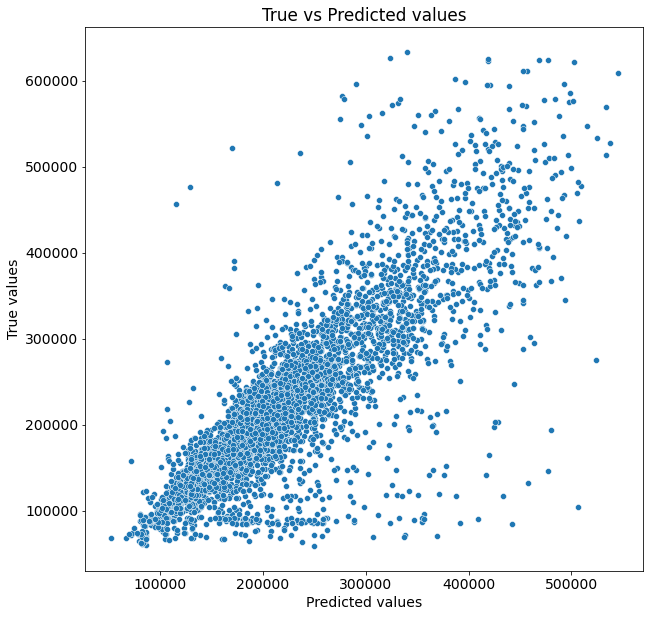

In [526]:
y_valid_preds = gb_model.predict(X_valid)
evaluate_preds(y_valid, y_valid_preds)

In [527]:
feature_importances = pd.DataFrame(zip(X_train.columns, gb_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
15,m2PriceByDistrict,0.310993
0,Rooms,0.296766
1,Square,0.136179
16,m2PriceByHouseYear,0.056571
5,HouseFloor,0.034336
3,KitchenSquare,0.027129
8,Social_1,0.027126
4,Floor,0.025963
2,LifeSquare,0.024450
7,Ecology_1,0.019756


## Сделаем тоже самое для тестового датасета

In [528]:
test_df.shape

(5000, 19)

In [529]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

In [530]:
test_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,8412.595400,51.279200,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,4832.674037,44.179466,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,1.000000,0.000000,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,4221.750000,21.000000,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,8320.500000,37.000000,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,12598.250000,77.000000,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,16795.000000,212.000000,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


In [531]:
test_df['Ecology_2_bin'] = test_df['Ecology_2'].replace({'A':0, 'B':1})
test_df['Ecology_3_bin'] = test_df['Ecology_3'].replace({'A':0, 'B':1})
test_df['Shops_2_bin'] = test_df['Shops_2'].replace({'A':0, 'B':1})

In [532]:
test_df['Rooms'].value_counts()

2.0     2030
1.0     1769
3.0     1099
4.0       90
5.0        7
0.0        2
6.0        2
17.0       1
Name: Rooms, dtype: int64

In [533]:
test_df.loc[test_df['Rooms'].isin([0, 6, 17]), 'Rooms'] = test_df['Rooms'].median()

In [534]:
test_df.loc[test_df['LifeSquare'].isnull(), 'LifeSquare'] = test_df['LifeSquare'].median()
test_df.loc[test_df['LifeSquare'] < 10, 'LifeSquare'] = 10
test_df.loc[test_df['LifeSquare'] > 100, 'LifeSquare'] = 100

In [535]:
test_df.loc[test_df['KitchenSquare'] < 6, 'KitchenSquare'] = test_df['KitchenSquare'].median()
test_df.loc[test_df['KitchenSquare'] > 20, 'KitchenSquare'] = test_df['KitchenSquare'].median()

In [536]:
test_df['Square'] = test_df['LifeSquare'] + test_df['KitchenSquare'] + 0.35 * (test_df['LifeSquare'] + test_df['KitchenSquare'])

In [537]:
test_df.loc[test_df['HouseFloor'] < test_df['Floor'], 'HouseFloor'] = test_df['Floor']

In [538]:
test_df.loc[test_df['HouseYear'] > 2021, 'HouseYear'] = 2021

In [539]:
test_df = test_df.merge(m2PriceByDistrict, on=['DistrictId'], how='left')
test_df = test_df.merge(m2PriceByHouseYear, on=['HouseYear'], how='left')

In [540]:
test_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,m2PriceByDistrict,m2PriceByHouseYear
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,4992.000000,4988.000000
mean,8412.595400,51.279200,1.906200,57.951979,35.499792,7.427600,8.632000,13.395000,1984.392600,0.119874,...,5406.900000,8.262600,1146.657263,1.31940,4.242800,0.990400,0.970200,0.917600,3789.931792,3701.893786
std,4832.674037,44.179466,0.805935,20.518059,14.736955,1.999189,5.483228,6.231945,18.573149,0.120070,...,4026.614773,23.863762,1044.744231,1.47994,4.777365,0.097518,0.170052,0.275001,919.214654,709.132573
min,1.000000,0.000000,1.000000,21.600000,10.000000,6.000000,1.000000,1.000000,1908.000000,0.000000,...,168.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,2000.730041,2531.023724
25%,4221.750000,21.000000,1.000000,44.885842,25.850152,6.000000,4.000000,9.000000,1973.000000,0.019509,...,1564.000000,0.000000,325.000000,0.00000,1.000000,1.000000,1.000000,1.000000,3020.720827,3055.453867
50%,8320.500000,37.000000,2.000000,52.548867,32.925087,6.000000,7.000000,14.000000,1977.000000,0.072158,...,5285.000000,2.000000,900.000000,1.00000,3.000000,1.000000,1.000000,1.000000,4025.455141,4033.486620
75%,12598.250000,77.000000,2.000000,66.513185,41.769526,9.000000,12.000000,17.000000,2000.000000,0.195781,...,7287.000000,5.000000,1548.000000,2.00000,6.000000,1.000000,1.000000,1.000000,4340.544855,4194.728461
max,16795.000000,212.000000,5.000000,157.950000,100.000000,20.000000,78.000000,99.000000,2020.000000,0.521867,...,19083.000000,141.000000,4849.000000,6.00000,23.000000,1.000000,1.000000,1.000000,8775.453771,8867.324983


In [541]:
test_df.isna().sum()

Id                       0
DistrictId               0
Rooms                    0
Square                   0
LifeSquare               0
KitchenSquare            0
Floor                    0
HouseFloor               0
HouseYear                0
Ecology_1                0
Ecology_2                0
Ecology_3                0
Social_1                 0
Social_2                 0
Social_3                 0
Healthcare_1          2377
Helthcare_2              0
Shops_1                  0
Shops_2                  0
Ecology_2_bin            0
Ecology_3_bin            0
Shops_2_bin              0
m2PriceByDistrict        8
m2PriceByHouseYear      12
dtype: int64

In [542]:
test_df.loc[test_df['m2PriceByDistrict'].isnull(), 'm2PriceByDistrict'] = m2PriceByDistrict['m2PriceByDistrict'].median()
test_df.loc[test_df['m2PriceByHouseYear'].isnull(), 'm2PriceByHouseYear'] = m2PriceByHouseYear['m2PriceByHouseYear'].median()

In [543]:
stand_features = scaler.fit_transform(test_df[feature_names])

In [544]:
test_df[feature_names] = pd.DataFrame(stand_features, columns=feature_names)

In [545]:
X_test = test_df[feature_names]

In [546]:
y_test_preds = gb_model.predict(X_test)

In [547]:
test_df['Price'] = y_test_preds

In [548]:
test_df.to_csv(PREDICTIONS_PATH, columns=['Id', 'Price'], index=False, encoding='utf-8')